# Loading data
## Install and Import packages


In [18]:
!pip install tensorflow
!pip install Keras
!pip install opencv-python
!pip install mlxtend

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from shutil import copy
from shutil import copytree, rmtree
from collections import defaultdict
import collections

import os

## Split dataset into train and test

In [20]:
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [21]:
# Train dataset 
print("Creating train data...")
# Change path  
prepare_data('/Users/dixonhu/Desktop/food-101/meta/train.txt', '/Users/dixonhu/Desktop/food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [22]:
# Test dataset
print("Creating test data...")
# Change path  
prepare_data('/Users/dixonhu/Desktop/food-101/meta/test.txt', '/Users/dixonhu/Desktop/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

## Data Argumentation

In [23]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) 
train_generator = train_datagen.flow_from_directory(
        "/Users/dixonhu/Desktop/food-101/train",        # Change path
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) 
test_generator = test_datagen.flow_from_directory(
        "/Users/dixonhu/Desktop/food-101/test",        # Change path
        target_size=(224,224),
        batch_size=64)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


## Check for invalid images

In [25]:
from PIL import Image 

def detect(data_dir):
    num = 0 
    for img_file in os.listdir(data_dir):
        path = os.path.join(data_dir,img_file)
        try:
            file_name = path
            img_file = Image.open(file_name)
        except:
            print('Not using this file, might be not an image:' + path)
            os.remove(path)

In [26]:
name_dir = '/Users/dixonhu/Desktop/food-101/train' 
for folder in os.listdir(name_dir):
    detect(os.path.join(name_dir,folder))
print("done")

done


In [27]:
name_dir = '/Users/dixonhu/Desktop/food-101/test' 
for folder in os.listdir(name_dir):
    detect(os.path.join(name_dir,folder))
print("done")

done


# Model

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = 75750/64,
                    validation_data=test_generator,
                    validation_steps= 25250/64,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

# Save the model for future 
model.save('model_trained_class.hdf5')

Epoch 1/10


KeyboardInterrupt: 

# Test

In [30]:
from tensorflow.keras.models import load_model

model_best = load_model('best_model_class.hdf5', compile = False)

In [32]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as img
from tensorflow.keras.preprocessing import image
import numpy as np

food_list = []
with open('/Users/dixonhu/Desktop/food-101/meta/classes.txt', 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        print(p)
        food_list.append(p)
        



apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito
bruschetta
caesar_salad
cannoli
caprese_salad
carrot_cake
ceviche
cheesecake
cheese_plate
chicken_curry
chicken_quesadilla
chicken_wings
chocolate_cake
chocolate_mousse
churros
clam_chowder
club_sandwich
crab_cakes
creme_brulee
croque_madame
cup_cakes
deviled_eggs
donuts
dumplings
edamame
eggs_benedict
escargots
falafel
filet_mignon
fish_and_chips
foie_gras
french_fries
french_onion_soup
french_toast
fried_calamari
fried_rice
frozen_yogurt
garlic_bread
gnocchi
greek_salad
grilled_cheese_sandwich
grilled_salmon
guacamole
gyoza
hamburger
hot_and_sour_soup
hot_dog
huevos_rancheros
hummus
ice_cream
lasagna
lobster_bisque
lobster_roll_sandwich
macaroni_and_cheese
macarons
miso_soup
mussels
nachos
omelette
onion_rings
oysters
pad_thai
paella
pancakes
panna_cotta
peking_duck
pho
pizza
pork_chop
poutine
prime_rib
pulled_pork_sandwich
ramen
ravioli
red_velvet_cake
risotto
sa

In [33]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

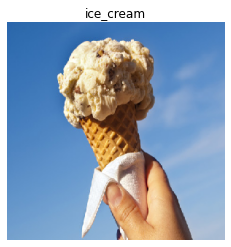

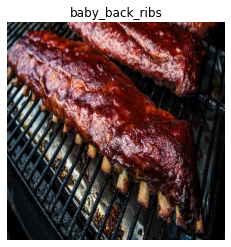

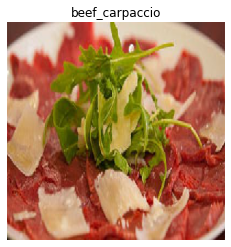

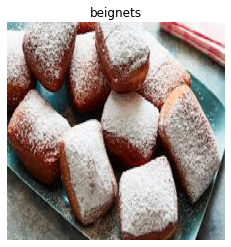

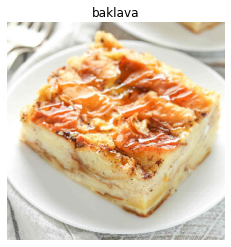

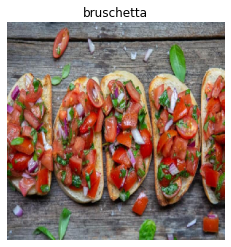

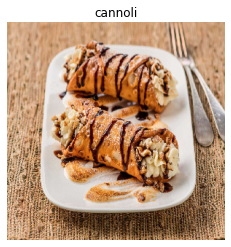

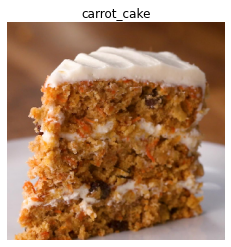

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dixonhu/Downloads/cheesecake1.jpg'

In [42]:
images = []

# Change path
images.append('/Users/dixonhu/Downloads/ice_cream1.jpg')
images.append('/Users/dixonhu/Downloads/baby_back_ribs1.jpeg')
images.append('/Users/dixonhu/Downloads/beef_carpaccio1.jpg')    

images.append('/Users/dixonhu/Downloads/beignets1.jpeg')
images.append('/Users/dixonhu/Downloads/bread_pudding1.jpg')
images.append('/Users/dixonhu/Downloads/bruschetta1.jpg')

images.append('/Users/dixonhu/Downloads/cannoli1.jpg')
images.append('/Users/dixonhu/Downloads/carrot_cake1.jpg')
images.append('/Users/dixonhu/Downloads/cheesecake1.jpg')


predict_class(model_best, images, True)